In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams['figure.figsize'] = (8, 6) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline
from wavenet import wavenetSC
from pallet import load_patches
                

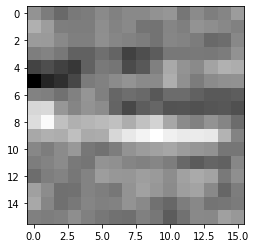

In [2]:
patches = load_patches(num_patches=50000, normalize=True)
plt.imshow(patches[42].reshape(16,16), cmap='gray')
plt.show()
patches = patches - np.mean(patches, axis=0)


In [3]:
wnsc = wavenetSC(num_inputs=patches.shape[1], num_outputs=1, num_units=1600, batch_size=250, lmda=.015, 
            lr_r=0.025, lr_W1=0.010, r1=3, r2=5, wi=5, we=30, sigmaE=3)


target sparsity: 10.00%


In [4]:
experiment_name = 'fig2'
print('Experiment: %s' % experiment_name)

Experiment: fig2


In [5]:
wnsc.W1 = np.load('fig2_normalized2_W1.npy')

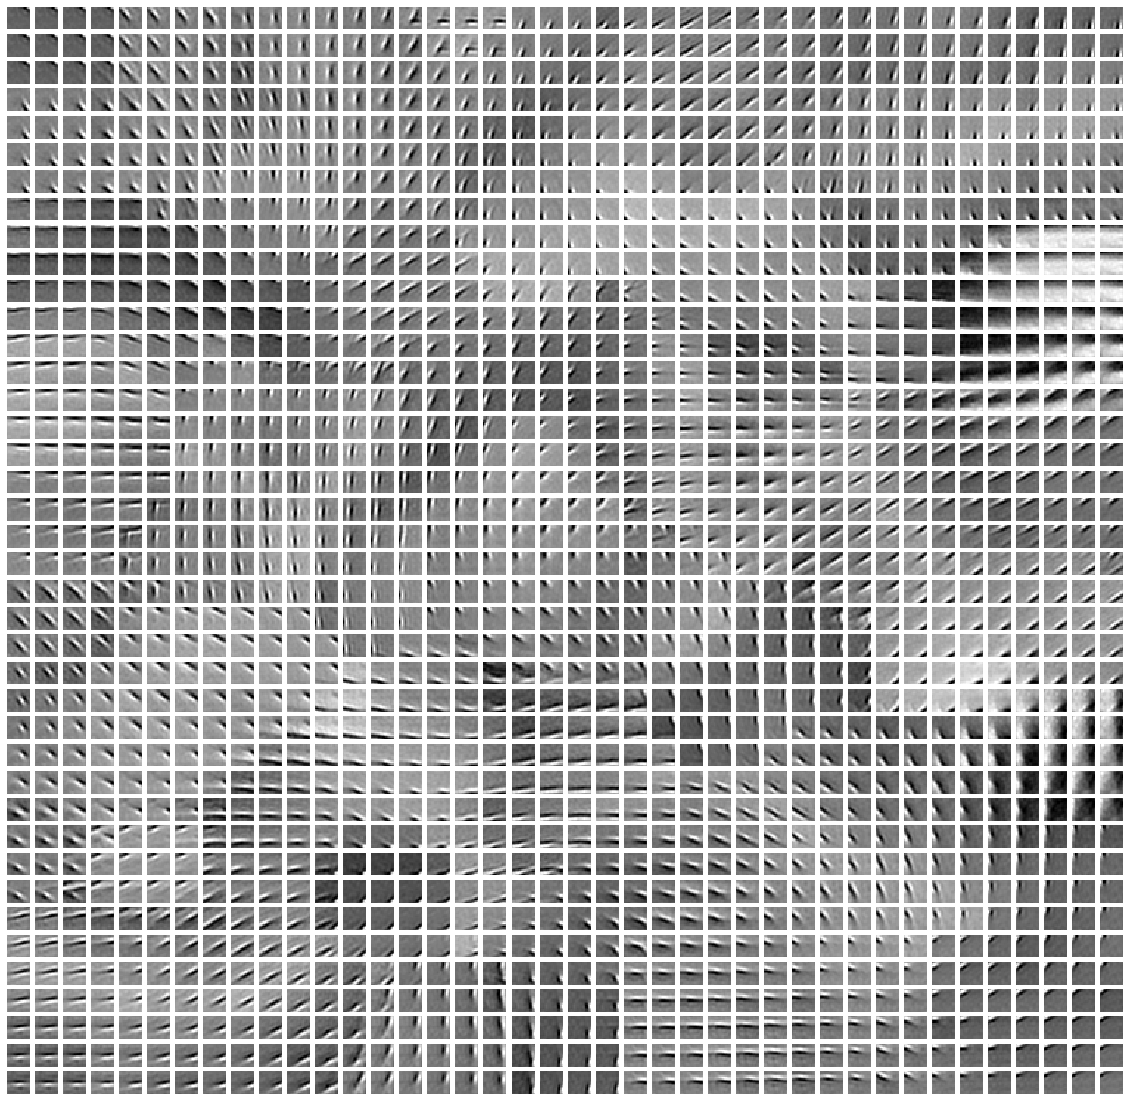

In [6]:
fig, ax = plt.subplots(40, 40, figsize=(20,20))
codewords = wnsc.W1.reshape((wnsc.W1.shape[0], 40, 40))
for i in np.arange(40):
    for j in np.arange(40):
        ax[i,j].imshow(codewords[:,i,j].reshape(16,16), cmap='binary')
        ax[i,j].axis('off')
#fig.tight_layout()

        

In [7]:
fig.savefig('%s_normalized_tunings.png' % 'fig2', bbox_inches='tight')


In [8]:
wnsc.lmda = 0.1
wnsc.cwsc.lmda  = 0.05
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
def load_patches(num_patches=10000, sz=16, normalize=True):
    #curl -O http://www.rctn.org/bruno/sparsenet/IMAGES.mat
    import scipy.io as scipio
    mat_images = scipio.loadmat('../data/IMAGES.mat')
    imgs = mat_images['IMAGES']
    H, W, num_images = imgs.shape
    patches = []
    # Get the coordinates of the upper left corner of randomly cropped image
    beginx = np.random.randint(0, W-sz, num_patches)
    beginy = np.random.randint(0, H-sz, num_patches)
    for i in range(num_patches):
        idx = np.random.randint(0, num_images)
        beginx = np.random.randint(0, W-sz)
        beginy = np.random.randint(0, H-sz)
        img = imgs[:, :, idx]
        crop = img[beginy:beginy+sz, beginx:beginx+sz].flatten()
        if normalize:
            crop = (crop - np.mean(crop))/np.std(crop)
        else:
            crop = crop - np.mean(crop)
        patches.append(crop)

    patches = np.array(patches)
    patches = patches.reshape(num_patches,sz*sz)
    # patches = patches.reshape(num_patches,sz,sz,1)
    patches = patches.astype('float32')
    return patches


In [10]:
import scipy.io as scipio
mat_imagesr = scipio.loadmat('../data/IMAGES_RAW.mat')
imgsr = mat_imagesr['IMAGESr']
mat_images = scipio.loadmat('../data/IMAGES.mat')
imgs = mat_images['IMAGES']

(-0.5, 511.5, 511.5, -0.5)

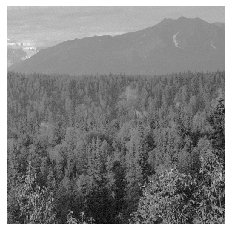

In [11]:
img = imgsr[:,:,7]
plt.imshow(img, cmap='gray')
plt.axis('off')

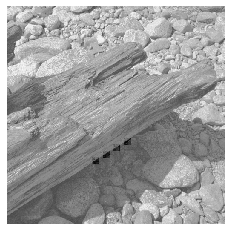

In [12]:
def extract_saccade(imno, coords, normalize=True, filename=''):
    sz = 16
    img = np.copy(imgsr[:,:,imno])
    H, W, num_images = imgs.shape
    for i in np.arange(len(coords)):
        beginx = coords[i][0]
        beginy = coords[i][1]
        crop = img[beginy:beginy+sz, beginx:beginx+sz]
        img[beginy:beginy+sz, beginx:beginx+sz] = 2*crop
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if len(filename) > 0:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
    patches = []
    for i in np.arange(len(coords)):
        img = imgs[:, :, imno]
        beginx = coords[i][0]
        beginy = coords[i][1]
        crop = img[beginy:beginy+sz, beginx:beginx+sz].flatten()
        if normalize:
            crop = (crop - np.mean(crop))/np.std(crop)
        else:
            crop = crop - np.mean(crop)
        patches.append(crop)
        
    patches = np.array(patches)
    patches = patches.reshape(len(coords), sz*sz)
    patches = patches.astype('float32')
    return patches
    
driftwood_edge = [(200,355),(225,340),(250,325),(275,310)] #,(300,290),(325,275), (350,260)]
ridgeline = [(200,64), (225,62), (250,62), (275,55)] #, (300,50), (325,45), (350,33)]


patches = extract_saccade(imno=0, coords=driftwood_edge)



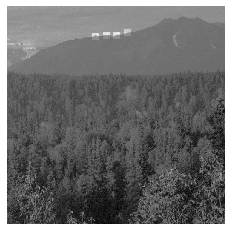

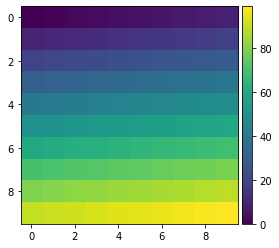

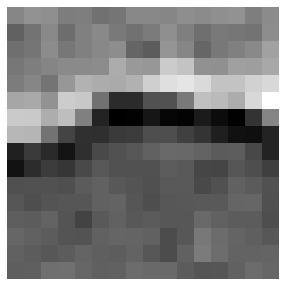

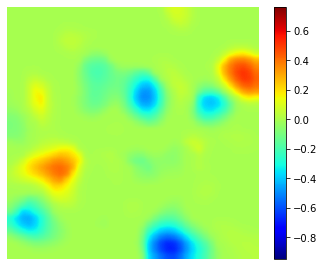

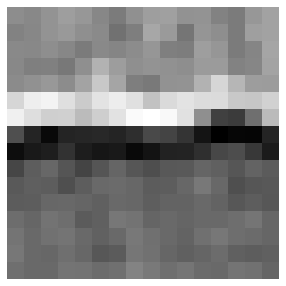

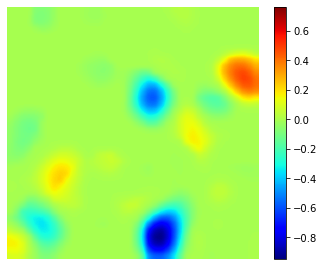

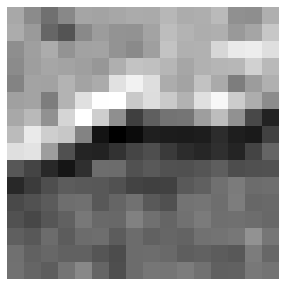

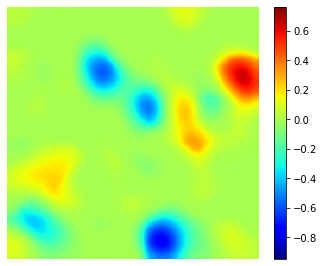

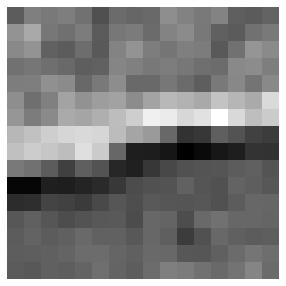

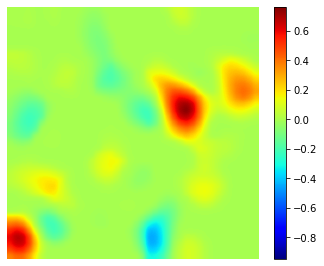

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
wnsc.cwsc.lmda = 0.03
imno, coords, name = 7, ridgeline, 'ridgeline'
patches = extract_saccade(imno=imno, coords=coords, filename='%s.pdf' % name)
activation, s = wnsc.compute_activations(patches)
stimulus = patches @ wnsc.W1
vmin = np.min(activation)
vmax = np.max(activation)
    
plt.figure()
ax = plt.gca()
im = ax.imshow(np.arange(100).reshape((10,10)))
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax)

for i in np.arange(len(patches)):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.imshow(patches[i,:].reshape(16, 16), cmap='binary_r', )
    ax.axis('off')
    plt.savefig('%s_patch_%d.png' % (name, i), bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    im = ax.imshow(activation[i,:].reshape(40,40), cmap='jet', interpolation='gaussian', vmin=vmin, vmax=vmax)
    ax.axis('off')
    plt.colorbar(im, cax=cax)
    plt.savefig('%s_activation_%d.png' % (name, i), bbox_inches='tight')
    plt.show()
